In [1]:
import sys
sys.path.append('..')

import config
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities import selected_venues as sv  # for reading the venues selected for this study

import multiprocessing as mp    # for multithreading
import scipy.optimize as optimization   #for fit
import inspect          #for fit
import os               # for reading directories
import gc               # for garbage collector

import scipy.stats      # for Spearman correlation
import seaborn as sns   #for plotting heatmaps

# Connect to MongoDB on Sophia
client = MongoClient(config.__host, config.__port)
papers_collection = client[config.__db_name][config.__collection_name]

mongo_input_limit = 400000    # maximum number of lines requested

print('Is connection estabilished? {0}'.format(papers_collection.find({}).count() != 0))

Is connection estabilished? True


## Input values and directories

In [2]:
###### constants

# minimum value of weight parameter on topic for deciding that a paper concerns the topic
minimum_topic_weight = 0.2
# time window of the model
T_0 = [2000, 2004]
# the starting year for studying the topic diffusion: it must be in the range (training_starting_year, training_ending_year)
diffusion_starting_year      = 2005
# the ending year for studying the topic diffusion: it must be in the range [diffusion_starting_year, training_ending_year)
diffusion_ending_year        = 2014

# directory containing data files
DATA_DIR = "../data"
images_dir = DATA_DIR+"/images"
diffusion_dir = DATA_DIR+"/diffusion"
innovation_dir = DATA_DIR+"/innovation"

# number of topics in the model
number_of_topics = 50

# max value of delta
max_delta = 6

# file containing topics assignments
topics_assignments_filename = "../demo_files/2000-2004-"+str(number_of_topics)+"-2000-2014-paper-topicid.csv"

# file containing topic labels (written by human user)
topics_label_filename = "../demo_files/2000-2004-"+str(number_of_topics)+"-2000-2014-mapping-name-topicid.csv"

# columns used for calculating the ranking
column_innovation = "new_authors_cumulative"
column_diffusion = "new_authors_cumulative"
column_innovation_rank = column_innovation+"-a"
column_diffusion_rank = column_diffusion+"-a"

###### create directories

#create directory
def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

makedir(DATA_DIR)
makedir(images_dir)
makedir(diffusion_dir)
makedir(innovation_dir)

## Statistics on dataset

In [3]:
#get dataframe of items <paper_id, year, topic_id, topic_weight>
def get_papers(topic_id_filename, year_from, year_to):
    # get topics for each paper
    paper_topics = pd.read_csv(topic_id_filename, sep=';')
    # get year of each paper
    pipeline = [
                {'$match': {'year': {'$gte': year_from, '$lte': year_to}}}, # filter years
                {"$project": {'acm_id': '$acm_id', 'year':'$year'}}
    ]

    result = papers_collection.aggregate(pipeline)
    paper_year =  pd.DataFrame(list(result))
    del paper_year['_id']
    # merge for assigning topic and year to each paper
    res = paper_topics.merge(paper_year, how = "left", left_on = "acm_id", right_on = "acm_id")
    res.dropna(inplace=True)  # delete unfound years, if any
    return res

#plot dataframe of items <paper_id, year, topic_id>
def plot_papers_overview(csv, index, columns, cmap=plt.cm.Vega20, filename=""):
    t = csv[csv["topic_weight"] >= minimum_topic_weight].pivot_table(index=index, columns=columns, values='acm_id', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("papers")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.gcf().clear()
    return

#plot overview on statistics on papers
def plot_statistics_on_papers(topics_assignments_filename, year_from, year_to, output_dir=""):
    papers_csv = get_papers(topics_assignments_filename, year_from, year_to)
    filename = ""

    print("Number of papers concerning a topic by year")
    if output_dir != "":
        filename = output_dir+"/papers_in_topic"
    plot_papers_overview(papers_csv, 'topic_id', 'year', filename=filename)

    print("Number of papers published in each year by topic")
    if output_dir != "":
        filename = output_dir+"/papers_in_year"
    plot_papers_overview(papers_csv, 'year', 'topic_id', cmap=plt.cm.gist_rainbow, filename=filename)

    print("Number of papers published in each year")
    return papers_csv[papers_csv["topic_weight"] >= minimum_topic_weight].groupby("topic_id").count().reset_index().sort_values(by="acm_id", ascending=False)
    #return


Number of papers concerning a topic by year


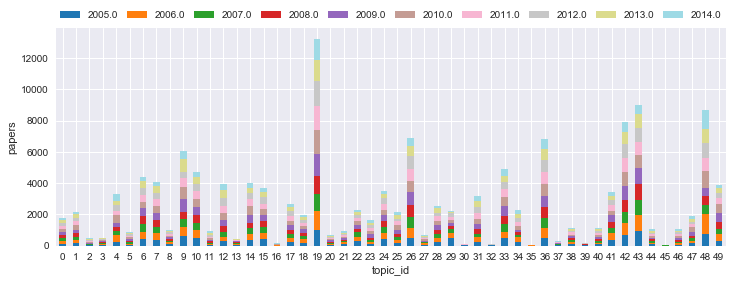

Number of papers published in each year by topic


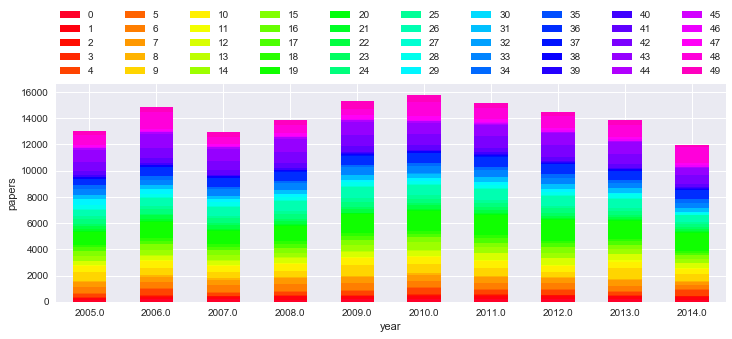

Number of papers published in each year


,topic_id,acm_id,topic_weight,year
19,19,13231,13231,13231
43,43,8969,8969,8969
48,48,8646,8646,8646
42,42,7913,7913,7913
26,26,6874,6874,6874
36,36,6833,6833,6833
9,9,6077,6077,6077
33,33,4899,4899,4899
10,10,4724,4724,4724
6,6,4423,4423,4423


In [4]:
plot_statistics_on_papers(topics_assignments_filename, diffusion_starting_year, diffusion_ending_year, output_dir=images_dir)

In [5]:
#get dataframe of items <paper_id, author_name, year, topic_id, topic_weight>
def get_authors(topic_id_filename, year_from, year_to):
    # get topics for each paper
    paper_topics = pd.read_csv(topic_id_filename, sep=';')
    # get years and authors of each paper
    pipeline = [
                {'$match': {'year': {'$gte': year_from, '$lte': year_to}}}, # filter years
                {'$unwind': '$authors'}, 
                {"$project": {'acm_id': '$acm_id', 'year':'$year', 'author': '$authors'}}
    ]

    result = papers_collection.aggregate(pipeline)
    paper_year_authors =  pd.DataFrame(list(result))
    del paper_year_authors['_id']
    # merge for assigning topic and year to each author
    res = paper_topics.merge(paper_year_authors, how = "left", left_on = "acm_id", right_on = "acm_id")
    res.dropna(inplace=True)  # delete unfound years, if any
    res[['year']] = res[['year']].astype(int)
    return res

#plot dataframe of items <paper_id, author_name, year, topic_id> letting the authors to repeat in the count
def plot_authors_overview(authors_csv, index, column, cmap=plt.cm.Vega20, filename=""):
    t = authors_csv[authors_csv["topic_weight"] >= minimum_topic_weight].pivot_table(index=index, columns=column, values='acm_id', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("authors")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.gcf().clear()
    return

#plot dataframe of items <paper_id, author_name, year, topic_id> where the authors are not repeated in the count
def plot_authors_norep_overview(authors_csv, index, column, cmap=plt.cm.Vega20, filename=""):
    t = authors_csv[authors_csv["topic_weight"] >= minimum_topic_weight].groupby(["topic_id","year","author"]).count().reset_index().groupby(["topic_id","year"]).count().reset_index().pivot_table(index=index, columns=column, values='acm_id', aggfunc='sum')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("authors")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.gcf().clear()
    return

#plot number of topics concerned by an author
def plot_author_overview(authors_csv, author, index, column, cmap=plt.cm.Vega20, weight=minimum_topic_weight, filename=""):
    t = authors_csv[(authors_csv["author"] == author) & (authors_csv["topic_weight"] >= weight)].pivot_table(index=index, columns=column, values='topic_weight', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(ncol=2)
    plt.ylabel("papers")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.gcf().clear()
    return

#plot overview on statistics on authors
def plot_statistics_on_authors(topics_assignments_filename, year_from, year_to, output_dir=""):
    authors_csv = get_authors(topics_assignments_filename, 2005, 2014)
    filename = ""

    print("Number of authors (with repetitions) concerning a topic by year")
    if output_dir != "":
        filename = output_dir+"/authors_in_topic"
    plot_authors_overview(authors_csv,'topic_id', 'year', filename=filename)

    print("Number of authors (with repetitions) publishing a paper in each year by topic")
    if output_dir != "":
        filename = output_dir+"/authors_in_year"
    plot_authors_overview(authors_csv, 'year', 'topic_id', cmap=plt.cm.gist_rainbow, filename=filename)

    print("Number of authors (without repetitions) concerning a topic by year")
    if output_dir != "":
        filename = output_dir+"/authors_in_topic-norep"
    plot_authors_norep_overview(authors_csv, 'topic_id', 'year', filename=filename)

    print("Number of authors (without rauthors_csv,epetitions) publishing a paper in each year by topic")
    if output_dir != "":
        filename = output_dir+"/authors_in_year-norep"
    plot_authors_norep_overview(authors_csv, 'year', 'topic_id', cmap=plt.cm.gist_rainbow, filename=filename)

    print("Number of authors (without repetitions) publishing a paper in each year")
    return authors_csv[authors_csv["topic_weight"] >= minimum_topic_weight].groupby(["topic_id","year","author"]).count().reset_index().groupby(["topic_id"]).count().reset_index().sort_values(by="acm_id", ascending=False)
    #return


Number of authors (with repetitions) concerning a topic by year


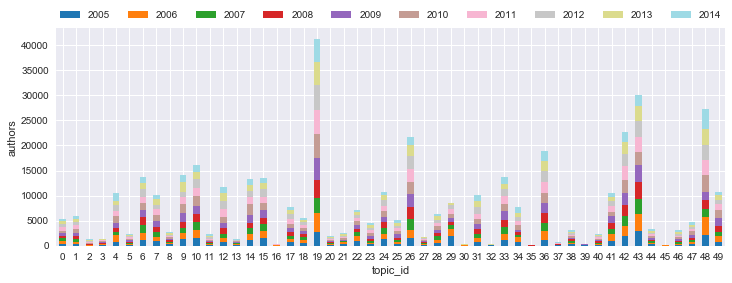

Number of authors (with repetitions) publishing a paper in each year by topic


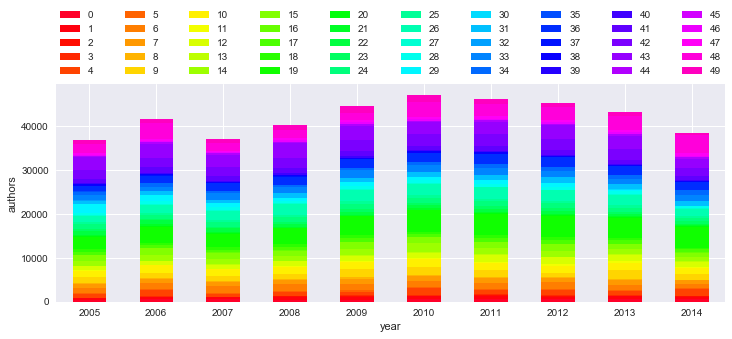

Number of authors (without repetitions) concerning a topic by year


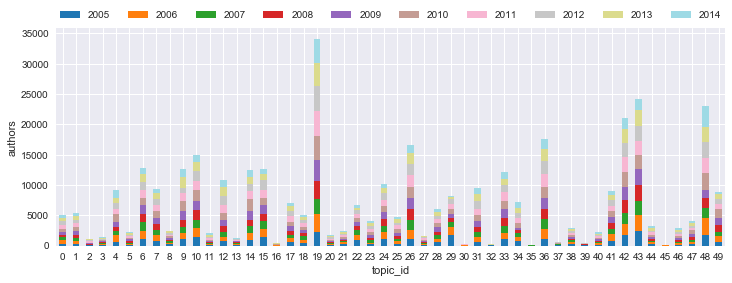

Number of authors (without rauthors_csv,epetitions) publishing a paper in each year by topic


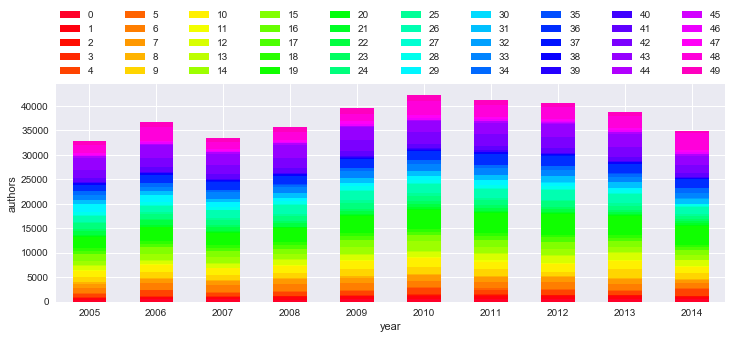

Number of authors (without repetitions) publishing a paper in each year


,topic_id,year,author,acm_id,topic_weight
19,19,34145,34145,34145,34145
43,43,24143,24143,24143,24143
48,48,23056,23056,23056,23056
42,42,21001,21001,21001,21001
36,36,17678,17678,17678,17678
26,26,16620,16620,16620,16620
10,10,14912,14912,14912,14912
6,6,12797,12797,12797,12797
15,15,12737,12737,12737,12737
9,9,12576,12576,12576,12576


In [6]:
plot_statistics_on_authors(topics_assignments_filename, diffusion_starting_year, diffusion_ending_year, output_dir=images_dir)

## Calculate ranks

In [7]:
################# begin fit code ########################
#

#linear function
def func_line(x, a, b):
    return a*x + b

#calculate fit
def get_fit(csv, topic_id_list, x_column, y_column, fit_func):
    result = {"topic_id": []}
    parameters = [x.name for x in inspect.signature(func_line).parameters.values()][1:]
    for parameter in parameters:
        result = {**result, **{y_column+"-"+parameter: [], y_column+"-stderr_"+parameter: []}}
    for topic_id in topic_id_list:
        topic_csv = csv[csv["topic_id"] == topic_id]
        popt, pcov = optimization.curve_fit(fit_func, range(len(topic_csv[y_column])), topic_csv[y_column])
        result["topic_id"] += [topic_id]
        for index, parameter in enumerate(parameters):
            result[y_column+"-"+parameter] += [popt[index]]
            result[y_column+"-stderr_"+parameter] += [np.sqrt(np.diag(pcov))[index]]
    return pd.DataFrame(result)

#plot fit
def plot_fit(baseline_csv, best_fit_csv, x_column, y_column, fit_func, topic_id_list=[], xticks_columns=[], filename=""):
    if topic_id_list == []:
        topic_id_list = best_fit_csv["topic_id"].unique()
    if len(topic_id_list) != 1:
        colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    else:
        colors = plt.cm.Vega20([0.0])
    #x_values = range(baseline_csv[x_column].min(), baseline_csv[x_column].max()+1)
    x_values = sorted(baseline_csv[x_column].unique())
    y_columns = [y_column+"-"+x.name for x in inspect.signature(func_line).parameters.values()][1:]
    for topic_id, color in zip(topic_id_list, colors):
        #popt = best_fit_csv[best_fit_csv["topic_id"] == topic_id][[y_column+"-a", y_column+"-b"]].values[0]
        popt = best_fit_csv[best_fit_csv["topic_id"] == topic_id][y_columns].values[0]
        plt.plot(x_values, fit_func(range(len(x_values)), *popt), '--', color=color, label="_none")
        plt.plot(x_values, baseline_csv[baseline_csv["topic_id"] == topic_id][y_column], '-', color=color, label="_none")
        plt.bar([x_values[0]], [0], color=color, label="topic "+str(topic_id))
    for linestyle, label in zip(["--", "-"], ["best fit", "baseline"]):
        plt.plot([], [], linestyle, color="grey", label=label)
    if xticks_columns != []:
        plt.xticks(x_values, [str(x)[-2:]+"-"+str(y)[-2:] for x, y in zip(list(baseline_csv[xticks_columns[0]]), list(baseline_csv[xticks_columns[1]]))])#, rotation=45, horizontalalignment='right')
    plt.legend()
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

#
################# end fit code ########################


################# begin parallelization code ########################
#

def parallelize_func(func, item_list, frm, length, return_dict, *args):
    for item in item_list[frm: min(len(item_list),(frm+length))]:
        return_dict[item] = func(item, *args)
    return

def parallelize(func, item_list, num_threads, *args):
    if num_threads == 0:
        num_threads = mp.cpu_count()
    # number of items for each thread
    # in python 3, the result of a division is a float!!
    delta = len(item_list)/num_threads
    if (delta).is_integer():
        delta = int(delta)
    else:
        delta = int(delta) + 1
        
    manager = mp.Manager()
    return_dict = manager.dict()

    jobs = []
    for thread in range(num_threads):
        p = mp.Process(target=parallelize_func, args=(func, item_list, thread*delta, delta, return_dict, *args))#(G, centrality_func, author_list, thread*delta, delta, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    
    return return_dict.items()

#
################# end parallelization code ########################

################# begin diffusion rank code ########################
#

#get dataframe that count the number of authors by year and topic_id
#   all_authors: all the authors publishing a paper on the topic in the year
#   new_authors: the same of all_authors, but the authors already found in previous years are not counted
#   *_cumulative: cumulative of *
def count_authors_in_topic(topic_id_list, authors_csv, year_from=None, year_to=None):
    result = {"topic_id": [], "year": [], "all_authors": [], "new_authors": [], "all_authors_cumulative": [], "new_authors_cumulative": []}
    for topic_id in topic_id_list:
        total_authors_sum = 0
        new_authors_sum = 0
        all_authors = []
        if year_from == None:
            year_from = authors_csv["year"].min()
        if year_to == None:
            year_to = authors_csv["year"].max() + 1
        for year in range(year_from, year_to):
            result["topic_id"] += [topic_id]
            result["year"] += [year]
            authors_of_year = set(authors_csv[(authors_csv["topic_weight"] >= minimum_topic_weight) & (authors_csv["year"] == year) & (authors_csv["topic_id"] == topic_id)]["author"])
            total_authors_sum += len(authors_of_year)
            result["all_authors"] += [len(authors_of_year)]
            result["all_authors_cumulative"] += [total_authors_sum]
            # count new authors
            new_authors = list(authors_of_year - set(all_authors))
            new_authors_sum += len(new_authors)
            #new_authors_count += [new_authors_sum]
            result["new_authors"] += [len(new_authors)]
            result["new_authors_cumulative"] += [new_authors_sum]
            all_authors += new_authors   
    return pd.DataFrame(result)

#calculate diffusion values in a years range
def save_diffusion(authors_csv, year_from, year_to, filename):
    topic_ids_local = authors_csv["topic_id"].unique()
    number_of_authors_in_topic = count_authors_in_topic(topic_ids_local, authors_csv, year_from, year_to)
    #save files
    number_of_authors_in_topic.to_csv(filename+"topics.csv", index=False)
    return

#calculate diffusion rank from file
def save_diffusion_rank(filename, column_to_fit, output_filename, fit_func=func_line, fit_param="a"):
    #read files
    number_of_authors_in_topic = pd.read_csv(filename)
    topic_ids_local = number_of_authors_in_topic["topic_id"].unique()
    #fit
    result = get_fit(number_of_authors_in_topic, topic_ids_local, "year", column_to_fit, fit_func)
    result = result.sort_values(by=column_to_fit+"-"+fit_param, ascending=False).reset_index()
    topics_to_plot = list(result["topic_id"][:5])
    #save files
    result.to_csv(output_filename+"diffusion_rank.csv", index=False)
    #plot and save fit 
    plot_fit(number_of_authors_in_topic, result, "year", column_to_fit, fit_func, topic_id_list=topics_to_plot, filename=output_filename+"diffusion_rank")
    return result
#
################# end diffusion rank code ########################

################# begin innovation rank code ########################
#

#get the citations tree of a list of papers in a range of years
def get_paper_citations_tree(target_list, year_from, year_to):
    new_target_list = set(target_list)
    result_list = []
    mongo_input_limit = 400000 # limits of results Mongo can get

    while bool(new_target_list):
        temp_result_list = []
        for i in range(int(len(new_target_list)/mongo_input_limit)+1):
            pipeline = [
                {'$match': {'year': {'$gte': year_from, '$lte': year_to}}}, # filter years
                {'$match': {'cleaned_venue': {'$in': sv.considered_venues}}}, # filter venues
                {'$match': {'acm_citations': {'$in': list(new_target_list)[i*mongo_input_limit:(i+1)*mongo_input_limit] }}},
                {"$project": {'acm_id': '$acm_id'}},
            ]

            result = papers_collection.aggregate(pipeline)
            temp_result_list += list(result)
        new_target_list = set([x['acm_id'] for x in list(temp_result_list)])-set(result_list)
        result_list += list(new_target_list)
    return result_list

#get dataframe that count the number of authors that have cited a paper published on topic in the previous time window
#the first time window is the years in range [source_years[0], source_years[1]], or source_years if it is not a list
#   all_authors: all the authors citing a paper in the previous time window
#   new_authors: the same of all_authors, but the authors already found in previous time windows are not counted
#   all_authors_intopic: all the authors citing with a paper on topic a paper in the previous time window
#   new_authors_intopic: the same of all_authors_intopic, but the authors already found in previous time windows are not counted
#   *_cumulative: cumulative of *
def count_authors_time_windows(topic_id_list, T_0, time_windows, authors_csv, papers_csv):
    if not isinstance(topic_id_list, list):
        topic_id_list = [topic_id_list]
    result = {"topic_id": [], "time_window_from": [], "time_window_to": [], "all_authors": [], "new_authors": [], "all_authors_cumulative": [], "new_authors_cumulative": [], "all_authors_intopic": [], "new_authors_intopic": [], "all_authors_intopic_cumulative": [], "new_authors_intopic_cumulative": []}
    for topic_id in topic_id_list:
        source_papers = list(papers_csv[(papers_csv["year"].isin([x for x in range(T_0[0], T_0[1]+1)])) & (papers_csv["topic_id"] == topic_id) & (papers_csv["topic_weight"] >= minimum_topic_weight)]["acm_id"])
        all_authors = list(authors_csv[authors_csv["acm_id"].isin(source_papers)]["author"])#[]
        all_authors_in_topic = list(authors_csv[authors_csv["acm_id"].isin(source_papers)]["author"])#[]
        sum_authors = 0; sum_new_authors = 0; sum_authors_in_topic = 0; sum_new_authors_in_topic = 0
        #add other time windows
        for time_window in time_windows:
            result["topic_id"] += [topic_id]
            result["time_window_from"] += [time_window[0]]
            result["time_window_to"] += [time_window[1]]
            paper_citations_tree = pd.DataFrame(get_paper_citations_tree(source_papers, time_window[0], time_window[1]), columns=["acm_id"]).merge(authors_csv, how = "left", left_on = "acm_id", right_on = "acm_id")
            authors_of_time_window = set(paper_citations_tree["author"])
            sum_authors += len(authors_of_time_window)
            result["all_authors"] += [len(authors_of_time_window)]
            result["all_authors_cumulative"] += [sum_authors]
            new_authors = list(authors_of_time_window - set(all_authors))
            sum_new_authors += len(new_authors)
            result["new_authors"] += [len(new_authors)]
            result["new_authors_cumulative"] += [sum_new_authors]
            all_authors += new_authors  
            # autohrs in topic
            authors_of_time_window_in_topic = set(paper_citations_tree[(paper_citations_tree["topic_id"] == topic_id) & (paper_citations_tree["topic_weight"] >= minimum_topic_weight)]["author"])
            sum_authors_in_topic += len(authors_of_time_window_in_topic)
            result["all_authors_intopic"] += [len(authors_of_time_window_in_topic)]
            result["all_authors_intopic_cumulative"] += [sum_authors_in_topic]
            new_authors_in_topic = list(authors_of_time_window_in_topic - set(all_authors_in_topic))
            sum_new_authors_in_topic += len(new_authors_in_topic)
            result["new_authors_intopic"] += [len(new_authors_in_topic)]
            result["new_authors_intopic_cumulative"] += [sum_new_authors_in_topic]
            all_authors_in_topic += new_authors_in_topic
            # update
            source_papers = paper_citations_tree[(paper_citations_tree["topic_id"] == topic_id) & (paper_citations_tree["topic_weight"] >= minimum_topic_weight)].groupby("acm_id").first().reset_index()["acm_id"]
    return pd.DataFrame(result)

# parallel version of function count_authors_time_windows
def count_authors_time_windows_parallel(topic_id_list, T_0, time_windows, authors_csv, papers_csv):
    res = parallelize(count_authors_time_windows, topic_id_list, 0, T_0, time_windows, authors_csv, papers_csv)
    result = pd.DataFrame()
    for r in res:
        result = result.append(r[1], ignore_index=True)
    return result

#calculate innovation for a single combination of T_0 and time windows
def save_innovation(papers_csv, authors_csv, T_0, time_windows, filename):
    topic_ids_local = papers_csv["topic_id"].unique()
    number_of_authors_time_windows = count_authors_time_windows_parallel(topic_ids_local, T_0, time_windows, authors_csv, papers_csv)
    #save files
    number_of_authors_time_windows.to_csv(filename+"time_windows.csv", index=False)
    return

#calculate innovation rank from file
def save_innovation_rank(filename, column_to_fit, output_filename, fit_func=func_line, fit_param="a"):
    #read files
    number_of_authors_time_windows = pd.read_csv(filename)
    topic_ids_local = number_of_authors_time_windows["topic_id"].unique()
    #fit
    result = get_fit(number_of_authors_time_windows, topic_ids_local, "time_window_to", column_to_fit, fit_func)
    result = result.sort_values(by=column_to_fit+"-"+fit_param, ascending=False).reset_index()
    topics_to_plot = list(result["topic_id"][:5])
    #save files
    result.to_csv(output_filename+"innovation_rank.csv", index=False)
    #plot and save fit 
    plot_fit(number_of_authors_time_windows, result, "time_window_to", column_to_fit, fit_func, topic_id_list=topics_to_plot, xticks_columns=["time_window_from","time_window_to"], filename=output_filename+"innovation_rank")
    return result
#
################# end innovation rank code ########################

#calculate time windows
def get_time_windows(year_from, year_to, delta, gamma):
    delta-=1; gamma -= 1; year_to+= 1
    res = []
    i = 0
    while (year_from + i*(delta-gamma) + delta) < year_to:
        res += [[year_from + i*(delta-gamma), year_from + i*(delta-gamma) + delta]]
        i += 1
    return res

#calculate rank for several values of delta and gamma
def save_diffusion_and_innovation(topics_assignments_filename, T_0, year_from, year_to, max_delta, number_of_topics, diffusion_dir, innovation_dir, min_delta=1, min_gamma=0):
    papers_csv_local = get_papers(topics_assignments_filename, T_0[0], year_to)
    authors_csv_local = get_authors(topics_assignments_filename, T_0[0], year_to)
    save_diffusion(authors_csv_local, year_from, year_to, diffusion_dir+"/"+str(number_of_topics)+"-")
    for delta in range(min_delta, max_delta+1):
        for gamma in range(min_gamma, delta):
            output_dir = innovation_dir+"/"+str(delta)+"-"+str(gamma)
            makedir(output_dir)
            output_dir += "/"+str(number_of_topics)+"-"
            time_windows = get_time_windows(year_from, year_to, delta, gamma)
            print("### T_0:", T_0, ", delta:", delta, ", gamma:", gamma, ", time windows:", time_windows)
            #save innovation values
            save_innovation(papers_csv_local, authors_csv_local, T_0, time_windows, output_dir)
    return

#calculate rank for several values of delta and gamma
def save_diffusion_and_innovation_ranks(T_0, year_from, year_to, max_delta, number_of_topics, column_diffusion, column_innovation, diffusion_dir, innovation_dir, min_delta=1, min_gamma=0):#, output_dir=DATA_DIR):
    #save diffusion rank
    print("######### diffusion rank")
    save_diffusion_rank(diffusion_dir+"/"+str(number_of_topics)+"-topics.csv", column_diffusion, diffusion_dir+"/"+str(number_of_topics)+"-", fit_func=func_line, fit_param="a")
    #save innovation ranks
    print("######### innovation rank")
    for delta in range(min_delta, max_delta+1):
        for gamma in range(min_gamma, delta):
            output_dir_delta = innovation_dir+"/"+str(delta)+"-"+str(gamma)
            print("### T_0:", T_0, ", delta:", delta, ", gamma:", gamma)
            try:
                save_innovation_rank(output_dir_delta+"/"+str(number_of_topics)+"-time_windows.csv", column_innovation, output_dir_delta+"/"+str(number_of_topics)+"-")
            except:
                print("Unexpected error:", sys.exc_info()[0])
            gc.collect()
    return


In [8]:
save_diffusion_and_innovation(topics_assignments_filename, T_0, diffusion_starting_year, diffusion_ending_year, max_delta, number_of_topics, diffusion_dir, innovation_dir)


### T_0: [2000, 2004] , delta: 1 , gamma: 0 , time windows: [[2005, 2005], [2006, 2006], [2007, 2007], [2008, 2008], [2009, 2009], [2010, 2010], [2011, 2011], [2012, 2012], [2013, 2013], [2014, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 2 , gamma: 0 , time windows: [[2005, 2006], [2007, 2008], [2009, 2010], [2011, 2012], [2013, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 2 , gamma: 1 , time windows: [[2005, 2006], [2006, 2007], [2007, 2008], [2008, 2009], [2009, 2010], [2010, 2011], [2011, 2012], [2012, 2013], [2013, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 3 , gamma: 0 , time windows: [[2005, 2007], [2008, 2010], [2011, 2013]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 3 , gamma: 1 , time windows: [[2005, 2007], [2007, 2009], [2009, 2011], [2011, 2013]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 3 , gamma: 2 , time windows: [[2005, 2007], [2006, 2008], [2007, 2009], [2008, 2010], [2009, 2011], [2010, 2012], [2011, 2013], [2012, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 4 , gamma: 0 , time windows: [[2005, 2008], [2009, 2012]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 4 , gamma: 1 , time windows: [[2005, 2008], [2008, 2011], [2011, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 4 , gamma: 2 , time windows: [[2005, 2008], [2007, 2010], [2009, 2012], [2011, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 4 , gamma: 3 , time windows: [[2005, 2008], [2006, 2009], [2007, 2010], [2008, 2011], [2009, 2012], [2010, 2013], [2011, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 5 , gamma: 0 , time windows: [[2005, 2009], [2010, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 5 , gamma: 1 , time windows: [[2005, 2009], [2009, 2013]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 5 , gamma: 2 , time windows: [[2005, 2009], [2008, 2012]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 5 , gamma: 3 , time windows: [[2005, 2009], [2007, 2011], [2009, 2013]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 5 , gamma: 4 , time windows: [[2005, 2009], [2006, 2010], [2007, 2011], [2008, 2012], [2009, 2013], [2010, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 6 , gamma: 0 , time windows: [[2005, 2010]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 6 , gamma: 1 , time windows: [[2005, 2010]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 6 , gamma: 2 , time windows: [[2005, 2010], [2009, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 6 , gamma: 3 , time windows: [[2005, 2010], [2008, 2013]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 6 , gamma: 4 , time windows: [[2005, 2010], [2007, 2012], [2009, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

### T_0: [2000, 2004] , delta: 6 , gamma: 5 , time windows: [[2005, 2010], [2006, 2011], [2007, 2012], [2008, 2013], [2009, 2014]]


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#pymongo-fork-safe>
  "MongoClient opened before fork. Create MongoClient "
/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/pymongo/topology.py:145: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forki

######### diffusion rank


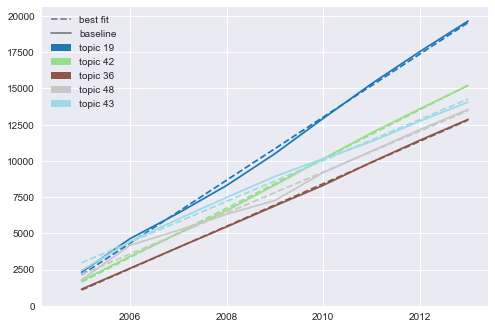

######### innovation rank
### T_0: [2000, 2004] , delta: 1 , gamma: 0


/home/livio/unito/temp/virtual_environments/tranet/.venv/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


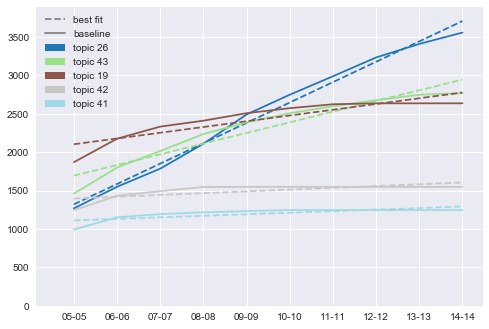

### T_0: [2000, 2004] , delta: 2 , gamma: 0


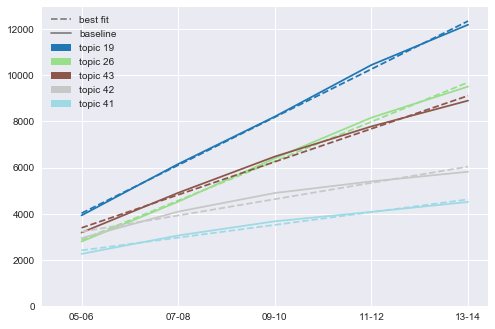

### T_0: [2000, 2004] , delta: 2 , gamma: 1


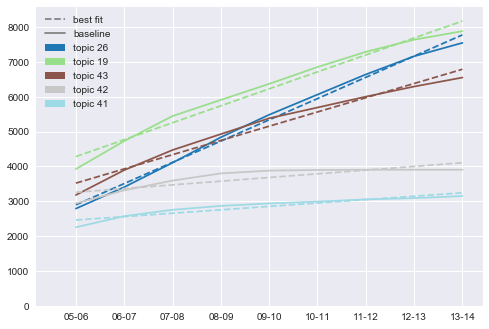

### T_0: [2000, 2004] , delta: 3 , gamma: 0


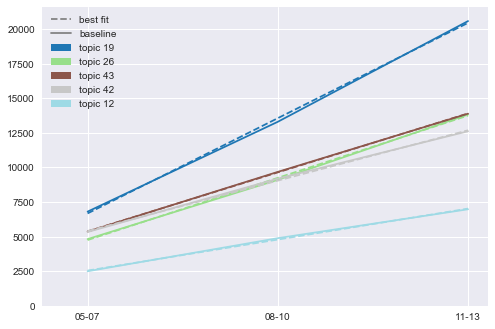

### T_0: [2000, 2004] , delta: 3 , gamma: 1


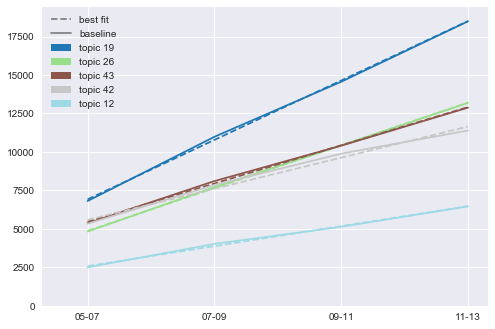

### T_0: [2000, 2004] , delta: 3 , gamma: 2


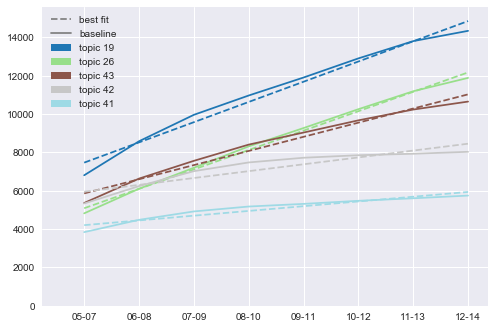

### T_0: [2000, 2004] , delta: 4 , gamma: 0


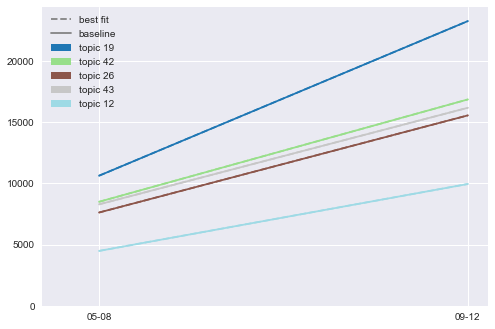

### T_0: [2000, 2004] , delta: 4 , gamma: 1


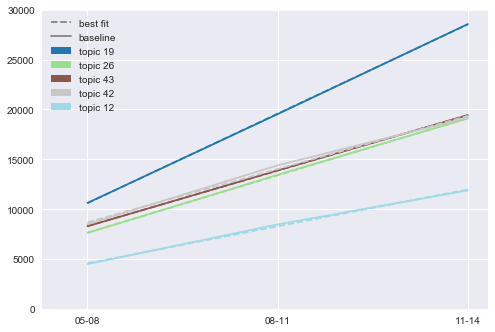

### T_0: [2000, 2004] , delta: 4 , gamma: 2


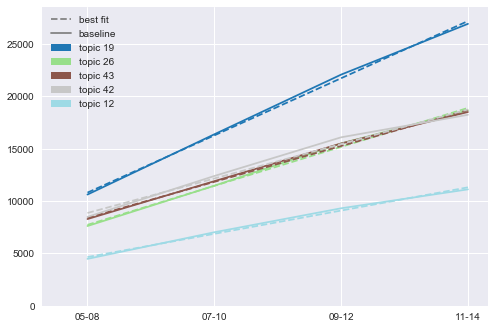

### T_0: [2000, 2004] , delta: 4 , gamma: 3


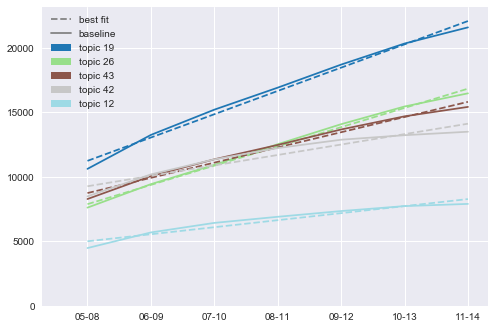

### T_0: [2000, 2004] , delta: 5 , gamma: 0


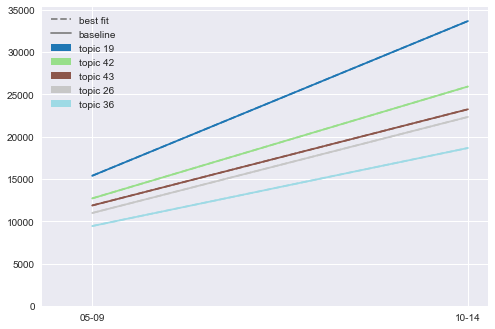

### T_0: [2000, 2004] , delta: 5 , gamma: 1


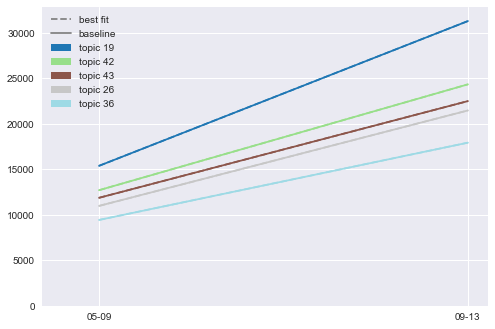

### T_0: [2000, 2004] , delta: 5 , gamma: 2


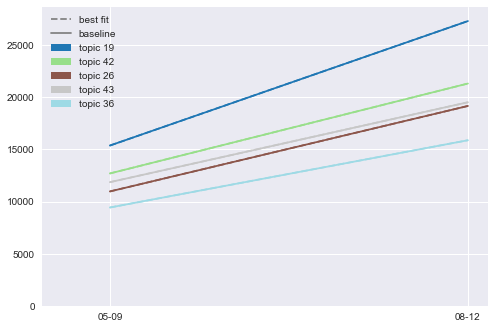

### T_0: [2000, 2004] , delta: 5 , gamma: 3


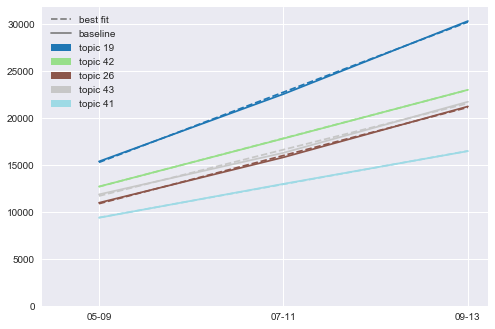

### T_0: [2000, 2004] , delta: 5 , gamma: 4


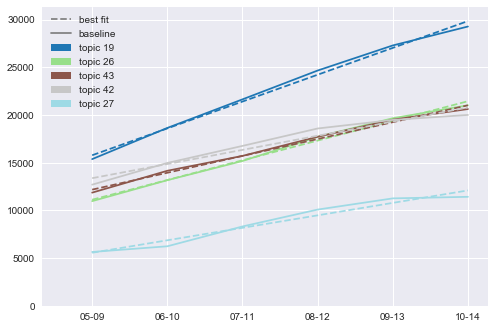

### T_0: [2000, 2004] , delta: 6 , gamma: 0
Unexpected error: <class 'TypeError'>
### T_0: [2000, 2004] , delta: 6 , gamma: 1
Unexpected error: <class 'TypeError'>
### T_0: [2000, 2004] , delta: 6 , gamma: 2


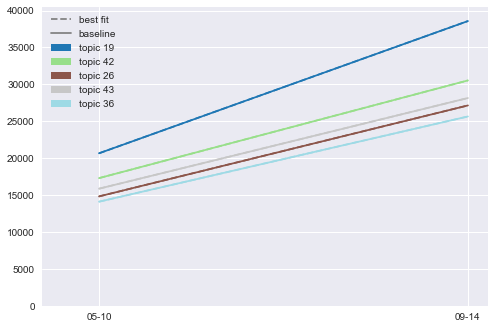

### T_0: [2000, 2004] , delta: 6 , gamma: 3


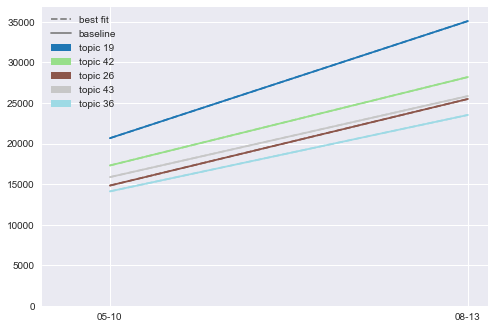

### T_0: [2000, 2004] , delta: 6 , gamma: 4


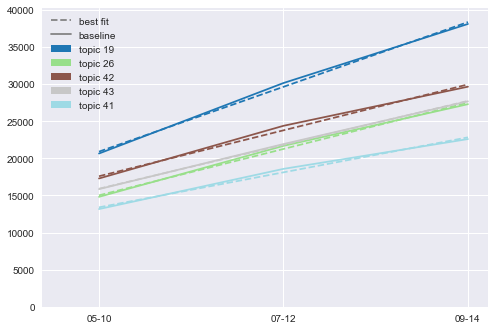

### T_0: [2000, 2004] , delta: 6 , gamma: 5


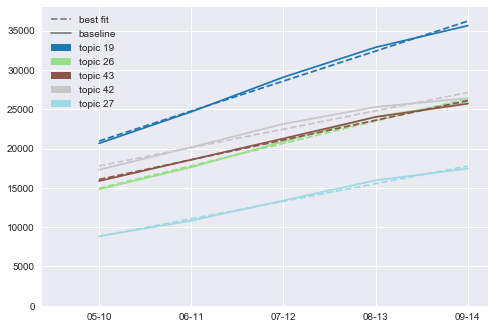

In [9]:
save_diffusion_and_innovation_ranks(T_0, diffusion_starting_year, diffusion_ending_year, max_delta, number_of_topics, column_diffusion, column_innovation, diffusion_dir, innovation_dir)#, min_delta=1, min_gamma=0, output_dir=DATA_DIR)


## Plot results

In [10]:
#get correlations between diffusion and innovation ranks
def get_correlations(max_delta, number_of_topics, column_innovation, column_diffusion, innovation_dir, diffusion_filename, rank_function):
    result = {}
    res = [[np.nan for x in range(max_delta+1)] for y in range(max_delta+1)]
    diffusion_rank = pd.read_csv(diffusion_filename)
    for delta in range(0, max_delta+1):
        for gamma in range(delta+1):
            try:
                innovation_rank = pd.read_csv(innovation_dir+"/"+str(delta)+"-"+str(gamma)+"/"+str(number_of_topics)+"-innovation_rank.csv")
                innovation_rank = innovation_rank.merge(diffusion_rank, left_on="topic_id", right_on="topic_id", suffixes=["_innovation","_diffusion"])[[column_innovation+"_innovation", column_diffusion+"_diffusion"]]  #(diffusion_rank)[[column_innovation, column_diffusion]]
                corr = rank_function(innovation_rank[column_innovation+"_innovation"].values, innovation_rank[column_diffusion+"_diffusion"].values)
                if rank_function == scipy.stats.pearsonr:
                    res[delta][gamma] = corr[0]
                else:
                    res[delta][gamma] = corr.correlation
            except:
                print("Unexpected error:", sys.exc_info()[0])
            gc.collect()
    return res

#plot generi heatmap
def plot_heatmap(res, title="", xlabel="", ylabel="", yticklabels=True, xticklabels=True, filename=""):
    mask = np.zeros_like(np.array(res))
    mask[np.where(np.isnan(np.array(res)))] = True
    ax = sns.heatmap(res, mask=mask, annot=True, fmt=".2f", square=1, linewidth=1., cmap=plt.cm.RdBu_r, yticklabels=yticklabels, xticklabels=xticklabels)
    for t in ax.texts:
        t.set_text(t.get_text())
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

#plot correlations between diffusion and innovation ranks
def plot_correlations(max_delta, number_of_topics, column_innovation, column_diffusion, innovation_dir, diffusion_filename, rank_function, min_delta=0, min_gamma=0, max_gamma=np.nan, title="", output_dir=""):
    correlations_local = get_correlations(max_delta, number_of_topics, column_innovation, column_diffusion, innovation_dir, diffusion_filename, rank_function)[min_delta:max_delta+1]
    if np.isnan(max_gamma):
        max_gamma = max_delta
    for index in range(len(correlations_local)):
        correlations_local[index] = correlations_local[index][min_gamma:max_gamma]
    if title != "":
        title = title+" "+str(number_of_topics)+" topics"
    if output_dir != "":
        filename = output_dir+"/correlation_inn_diff_"+str(number_of_topics)
    sns.set()
    plot_heatmap(correlations_local, title, r"$\gamma$", r"$\delta$", yticklabels=[x for x in range(min_delta, max_delta+1)], xticklabels=[x for x in range(min_gamma, max_gamma+1)], filename=filename)
    sns.reset_orig()
    return

Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>


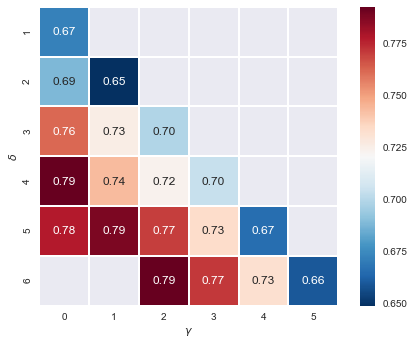

In [11]:
plot_correlations(max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", scipy.stats.spearmanr, min_delta=1, output_dir=images_dir)


In [12]:
def get_ranking(filename, ranking_column):
    ranking = pd.read_csv(filename).sort_values(by=ranking_column, ascending=False, inplace=False).reset_index()[["topic_id",ranking_column]]
    ranking["rank"] = ranking.index.values + 1
    return ranking[["topic_id","rank"]]

def get_innovation_rankings(max_delta, number_of_topics, ranking_column, ranking_dir, offset_filename):#=DATA_DIR+"topic_fit"):#, labels_dir=DATA_DIR+"topics_assignments", fixed_model_years=None):
    count = 0
    res = [[np.nan for x in range(max_delta+1)] for y in range(max_delta+1)]
    for delta in range(0, max_delta+1):
        for gamma in range(delta+1):
            filename = ranking_dir+"/"+str(delta)+"-"+str(gamma)+"/"+str(number_of_topics)+"-"+offset_filename
            try:
                temp = get_ranking(filename, ranking_column)#get_ranking(time_window_from, (time_window_from+time_window-1), overlap, number_of_topics, ranking_column, offset_filename, ranking_dir=ranking_dir)[["topic_id", "rank"]]
                temp.columns = ["topic_id", str(delta)+"-"+str(gamma)]
                if count == 0:
                    res = temp
                else:
                    res = res.merge(temp)
                count += 1
            except:
                print("Unexpected error:", sys.exc_info()[0])
    return res

def plot_ranking_topics_ax(ax, csv, topics_list, cmap=plt.cm.Vega20, topics_label_file=""):
    colors = cmap([x/float(len(topics_list)-1) for x in range(len(topics_list))])
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
    if topics_label_file != "":
        topics_label = pd.read_csv(topics_label_file, sep=';')
    for topic_id, color, marker in zip(topics_list, colors, markers):
        y_values = csv[csv["topic_id"] == topic_id].values[0][1:]
        label="topic "+str(topic_id)
        if topics_label_file != "":
            try:
                label = topics_label[topics_label["topic_id"] == topic_id]["label"].values[0]
            except:
                print("topic "+str(topic_id)+" not found")
        ax.plot(range(len(y_values)), y_values, color=color, marker=marker, label=label)
    return

#plot ranking for single value
def plot_ranking_topics_points_ax(ax, csv, topics_list, x_value, cmap=plt.cm.Vega20):
    colors = cmap([x/float(len(topics_list)-1) for x in range(len(topics_list))])
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
    for topic_id, color, marker in zip(topics_list, colors, markers):
        y_value = csv[csv["topic_id"] == topic_id].values[0][-1]
        ax.plot(x_value, y_value, "", color=color, marker=marker, label="_topic "+str(topic_id))
    return

#plot ranking for several values of delta and gamma
def plot_rankings_topics_comparison(topics_list, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename="", filename=""):
    innovation_rankings_csv = get_innovation_rankings(max_delta, number_of_topics, column_innovation, innovation_ranking_dir, innovation_offset_filename)
    diffusion_rankings_csv = get_ranking(diffusion_filename, column_diffusion)
    #plot
    print("########", number_of_topics, "topics")
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cmap=plt.cm.Vega20
    plot_ranking_topics_ax(ax, innovation_rankings_csv, topics_list, cmap=cmap, topics_label_file=topics_label_filename)
    plot_ranking_topics_points_ax(ax, diffusion_rankings_csv, topics_list, -1, cmap=cmap)
    plt.legend()
    #first axis
    xticks = ["diff."]
    xticks2_label_positions = [-0.5]
    temp_delta = [-1]
    delta_count = 1
    xticks2_labels = [delta_count]
    for index2, column in enumerate(innovation_rankings_csv.columns[1:]):
        xticks += [column[2:]]
        temp_delta += [int(column[0:1])]
        if delta_count != int(column[0:1]):
            delta_count = int(column[0:1])
            xticks2_label_positions += [index2-0.5]
            xticks2_labels += [delta_count]
    plt.xticks([-1]+[x for x in range(len(innovation_rankings_csv.columns)-1)], xticks)#, rotation='vertical')
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel(r"$\gamma$")
    #second axis
    newax = ax.twiny()
    newax.set_frame_on(True)
    newax.patch.set_visible(False)
    newax.xaxis.set_ticks_position('bottom')
    newax.xaxis.set_label_position('bottom')
    newax.spines['bottom'].set_position(('outward', 40))
    # add major ticks
    newax.set_xlim(ax.get_xlim())
    xticks2_label_positions += [newax.get_xlim()[1]]
    newax.set_xticks(xticks2_label_positions)
    newax.set_xticklabels('')
    # add minor ticks
    newax.set_xticks([(x + (y-x)/2.0) for x, y in zip(xticks2_label_positions,xticks2_label_positions[1:])], minor=True)
    newax.set_xticklabels(xticks2_labels, minor=True)
    # hide minor ticks
    for tick in newax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
    newax.set_xlabel(r"$\delta$")
    #plot
    plt.tight_layout()
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

#plot rankings of top range_k topics by innovation
def plot_rankings_comparison(range_k, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename="", filename=""):
    innovation_rankings_csv = get_innovation_rankings(max_delta, number_of_topics, column_innovation, innovation_ranking_dir, innovation_offset_filename)
    #get top topics for diffusion ranking
    if not isinstance(range_k, list):
        range_k = [0, range_k]
    innovation_rankings_csv["mean_rank"] = innovation_rankings_csv[innovation_rankings_csv.columns[1:]].mean(axis=1)
    topics_list = list(innovation_rankings_csv.sort_values(by = "mean_rank", ascending = True)["topic_id"])[range_k[0]:range_k[1]]
    plot_rankings_topics_comparison(topics_list, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename=topics_label_filename, filename=filename)
    return

#plot rankings of top range_k topics by diffusion
def plot_rankings_comparison_2(range_k, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename="", filename=""):
    diffusion_rankings_csv = get_ranking(diffusion_filename, column_diffusion)
    #get top topics for diffusion ranking
    if not isinstance(range_k, list):
        range_k = [0, range_k]
    topics_list = list(diffusion_rankings_csv.sort_values(by = "rank", ascending = True)["topic_id"])[range_k[0]:range_k[1]]
    plot_rankings_topics_comparison(topics_list, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename=topics_label_filename, filename=filename)
    return


Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
######## 50 topics


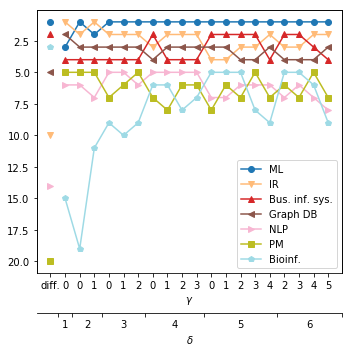

Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
######## 50 topics


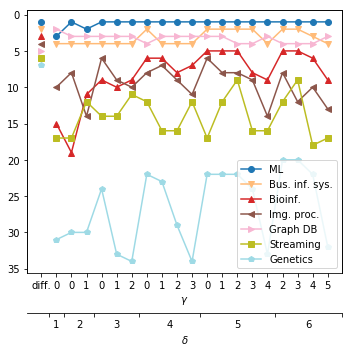

Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
######## 50 topics


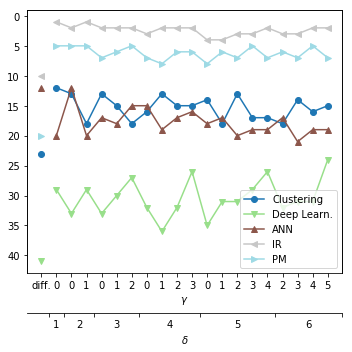

In [13]:
plot_rankings_comparison(7, max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, "innovation_rank.csv", diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", topics_label_filename=topics_label_filename, filename=images_dir+"/top_rankings_comparison_"+str(number_of_topics))

plot_rankings_comparison_2(7, max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, "innovation_rank.csv", diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", topics_label_filename=topics_label_filename, filename=images_dir+"/top_rankings_comparison_2_"+str(number_of_topics))

plot_rankings_topics_comparison([22,3,33,26,41], max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, "innovation_rank.csv", diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", topics_label_filename=topics_label_filename, filename=images_dir+"/topics_rankings_comparison_"+str(number_of_topics))


In [14]:
def plot_correlations_innovation(max_delta, number_of_topics, column_innovation, innovation_dir, rank_function, cmap=plt.cm.summer, filename=""):#, topics_label_filename=""):
    fig = plt.figure(figsize=(13,4))
    ax = fig.add_subplot(111)
    to_plot = []
    xticks_labels = []
    delta_index = []
    old_plot_length = -1
    plot_background = False
    for delta in range(2, max_delta+1):
        for gamma_1 in range(0, delta):
            for gamma_2 in range(gamma_1):
                try:
                    innovation_rank_1 = pd.read_csv(innovation_dir+"/"+str(delta)+"-"+str(gamma_1)+"/"+str(number_of_topics)+"-innovation_rank.csv")
                    innovation_rank_2 = pd.read_csv(innovation_dir+"/"+str(delta)+"-"+str(gamma_2)+"/"+str(number_of_topics)+"-innovation_rank.csv")
                    innovation_rank_1 = innovation_rank_1.merge(innovation_rank_2, left_on="topic_id", right_on="topic_id", suffixes=["_1","_2"])[[column_innovation+"_1", column_innovation+"_2"]]
                    corr = rank_function(innovation_rank_1[column_innovation+"_1"].values, innovation_rank_1[column_innovation+"_2"].values)
                    if rank_function == scipy.stats.pearsonr:
                        to_plot += [corr[0]]
                    else:
                        to_plot += [corr.correlation]
                    xticks_labels += ["("+str(gamma_2)+","+str(gamma_1)+")"]
                    delta_index += [delta]
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                gc.collect()
        #print text
        ax.text(old_plot_length+(len(to_plot) - old_plot_length )/2.0, 1.005, r"$\delta = "+str(delta)+"$",
            verticalalignment='center', horizontalalignment='center',fontsize=11)
        #add background
        if plot_background:
            plt.axvspan(old_plot_length, len(to_plot), color=str(0.9), alpha=0.5)
        plot_background = not(plot_background)
        #add empty space
        if delta != max_delta:
            old_plot_length = len(to_plot)
            to_plot += [0]
            xticks_labels += [""]
            delta_index += [delta]
    if max(delta_index)-min(delta_index) != 0:
        colors = cmap([x/float(max(delta_index)-min(delta_index)) for x in range(max(delta_index)-min(delta_index)+1)])
    else:
        colors = cmap([0.0])
    #plot
    plt.bar(range(len(to_plot)), to_plot, color=[colors[x-min(delta_index)] for x in delta_index])
    plt.xticks(range(len(to_plot)), xticks_labels)
    plt.ylim([0.7, 1.025])
    plt.xlim([-1, len(to_plot)])
    ax.set_xlabel(r'($\gamma_1$,$\gamma_2$)')
    #save
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>
Unexpected error: <class 'FileNotFoundError'>


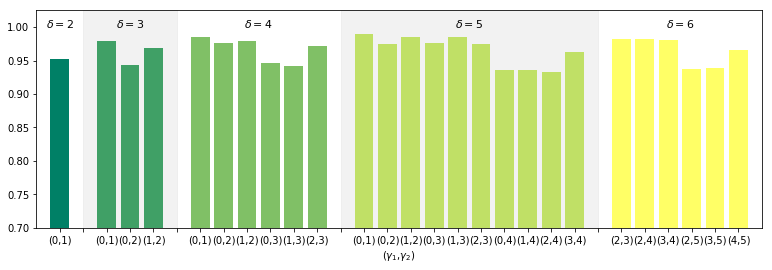

In [15]:
plot_correlations_innovation(max_delta, number_of_topics, column_innovation_rank, innovation_dir, scipy.stats.spearmanr, filename=images_dir+"/correlations_gamma_"+str(number_of_topics))


In [16]:
def plot_diffusion_values(diffusion_filename, topic_id_list, column_diffusion, topics_label_file="", filename=""):
    csv = pd.read_csv(diffusion_filename)
    if len(topic_id_list) == 1:
        colors = plt.cm.Vega20([0.0])
    else:
        colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    if topics_label_file != "":
        topics_label = pd.read_csv(topics_label_file, sep=';')
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for topic_id, color, linestyle in zip(topic_id_list, colors, linestyles):
        label="topic "+str(topic_id)
        if topics_label_file != "":
            try:
                label = topics_label[topics_label["topic_id"] == topic_id]["label"].values[0]
            except:
                print("topic "+str(topic_id)+" not found")
        plt.plot(csv[csv["topic_id"] == topic_id]["year"], csv[csv["topic_id"] == topic_id][column_diffusion], linestyle, color=color, label=label)
    plt.legend()
    #save
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

def plot_innovation_file(innovation_filename, topic_id_list, column_innovation, topics_label_file="", filename=""):
    csv = pd.read_csv(innovation_filename)
    if len(topic_id_list) == 1:
        colors = plt.cm.Vega20([0.0])
    else:
        colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    if topics_label_file != "":
        topics_label = pd.read_csv(topics_label_file, sep=';')
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for topic_id, color, linestyle in zip(topic_id_list, colors, linestyles):
        label="topic "+str(topic_id)
        if topics_label_file != "":
            try:
                label = topics_label[topics_label["topic_id"] == topic_id]["label"].values[0]
            except:
                print("topic "+str(topic_id)+" not found")
        plt.plot(csv[csv["topic_id"] == topic_id]["time_window_to"], csv[csv["topic_id"] == topic_id][column_innovation], linestyle, color=color, label=label)
    gap_between_xsticks = 1
    plt.xticks(csv[csv["topic_id"] == topic_id]["time_window_to"][::gap_between_xsticks], [str(x)[-2:]+"-"+str(y)[-2:] for x, y in zip(csv[csv["topic_id"] == topic_id]["time_window_from"][::gap_between_xsticks], csv[csv["topic_id"] == topic_id]["time_window_to"][::gap_between_xsticks])])#, rotation=45, horizontalalignment='right')
    plt.legend()
    #save
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

def plot_innovation_values(delta, gamma, number_of_topics, topic_id_list, column_innovation, innovation_dir, topics_label_file="", filename=""):
    return plot_innovation_file(innovation_dir+"/"+str(delta)+"-"+str(gamma)+"/"+str(number_of_topics)+"-time_windows.csv", topic_id_list, column_innovation, topics_label_file=topics_label_file, filename=filename)


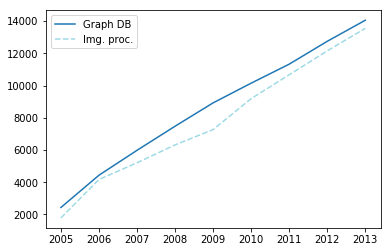

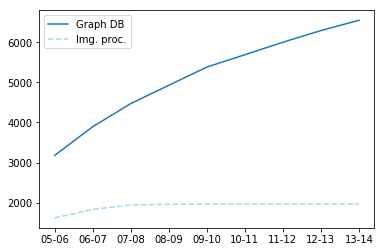

In [17]:
plot_diffusion_values(diffusion_dir+"/"+str(number_of_topics)+"-topics.csv", [43,48], column_diffusion, topics_label_file=topics_label_filename, filename=images_dir+"/diffusion_sample")
plot_innovation_values(2, 1, number_of_topics, [43,48], column_innovation, innovation_dir, topics_label_file=topics_label_filename, filename=images_dir+"/innovation_sample")
